<a id="top"></a>
 <font size="5">BAPC</font>
> 

> * Prepared by Alfredo López
> * alfredo.lopez@scch.at
> 
<hr>
<hr>

# Import

In [1]:
import os
import numpy as np
import pandas as pd
import pitsa_lite as pitsa
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

# Input

In [2]:
csv_file = '5_step_large'
#csv_file = '6_ramp_large'

base_model_name = 'Sklearn-Model'

#correction_model_name = 'KNN' # fast but less accurate forecast
correction_model_name = 'LSTM' # slow but more accurate forecast

# meta parameters
n_train = 96 # number of training samples, ie. the sliding window size
forecast_lenght = 0 # forecast lenght
correction_window = 48 # correction window size

# Folders

In [3]:
# Please enter the input data folder 
data_folder = '../../../2_data/processed/synthetic'

# Please enter the output figure folder
fig_base = '../../../4_results/figures'

# save the figures ?
save_fig = True

# current convention
notebook_name, _  = os.path.splitext(os.path.basename(globals()['__vsc_ipynb_file__']))
fig_folder = os.path.join(fig_base, notebook_name)

if save_fig and not os.path.exists(fig_folder):
    print('Folder {} was created'.format(fig_folder))
    os.mkdir(fig_folder)

# Data

Figure ../../../4_results/figures\2_6_bapc_sequential\5_step_large_seq_data.png was saved


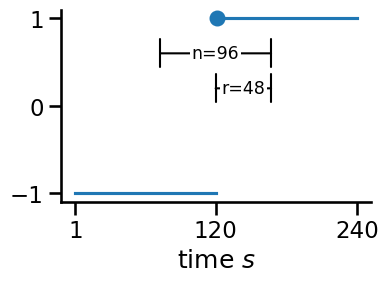

In [4]:
# time series reading
file_name = os.path.join(data_folder, csv_file + '.csv')
df = pd.read_csv(file_name, index_col='t')
df.reset_index(drop=True, inplace=True)

# plot
tast = 120
t = df.index.values
m_train = df.shape[0]

with sns.plotting_context("talk"):

    f, ax = plt.subplots(figsize=(4, 2.5))
    
    if csv_file == '5_step_large':
        ax.plot(t[:tast], df['y'].loc[:tast-1], color='tab:blue')
        ax.plot(t[tast:], df['y'].loc[tast:], color='tab:blue', label=r'$y$')
        ax.scatter(tast, df['y'].loc[tast], color='tab:blue', s=100)
    else:
        ax.plot(t, df['y'], color='tab:blue', label=r'$y$')

    xticks = np.array([0, tast-1, m_train-1])
    ax.set_xticks(xticks, labels=xticks+1)
    plt.locator_params(axis='y', nbins=3)
    ax.set_xlabel(r'time $s$')
    ax.set_ylabel('')

    x0 = 72
    x1 = tast - 1
    x2 = x1 + correction_window - 1

    ht = df['y'].min() + 0.8*(df['y'].max()-df['y'].min())
    ax.annotate("", xy=(x0, ht), xytext=(x2, ht), textcoords=ax.transData, arrowprops=dict(arrowstyle='|-|',mutation_scale=10, shrinkA=0, shrinkB=0))
    bbox=dict(fc="white", ec="none", boxstyle="square,pad=0.1")
    ax.text(x0 + (x2-x0)/2, ht, "n={}".format(n_train), ha="center", va="center", bbox=bbox, fontsize='x-small');

    ht = df['y'].min() + 0.6*(df['y'].max()-df['y'].min()) 
    ax.annotate("", xy=(x1, ht), xytext=(x2, ht), textcoords=ax.transData, arrowprops=dict(arrowstyle='|-|',mutation_scale=10, shrinkA=0, shrinkB=0))
    bbox=dict(fc="white", ec="none", boxstyle="square,pad=0.1")
    ax.text(x1 + (x2-x1)/2, ht, "r={}".format(correction_window), ha="center", va="center", bbox=bbox, fontsize='x-small');

    sns.despine()

    xlim = ax.get_xlim()

    if save_fig:
        fig_name = os.path.join(fig_folder,  '{}_seq_data.png'.format(csv_file))
        plt.savefig(fig_name, bbox_inches='tight', dpi=300)
        print('Figure {} was saved'.format(fig_name))

# Base model

In [5]:
if base_model_name == 'Sklearn-Model':
    if csv_file == '5_step_large':
        model = DummyRegressor(strategy="mean")
        base_model = pitsa.models.regression.SKLearnModel(model=model)
    elif csv_file == '6_ramp_large':
        model = LinearRegression(fit_intercept=True)
        base_model = pitsa.models.regression.SKLearnModel(model=model)
    else:
        raise ValueError('Model {} is not included'.format(csv_file))

else:
    error_msg = 'Model {} is not instantiated. Use this place to instantiate your new base model'.format(base_model_name)
    raise ValueError(error_msg)

# Correction model

In [6]:
if correction_model_name == 'KNN':
    model = KNeighborsRegressor(n_neighbors=1) #Set n_neighbors=1 for perfect fit
    correction_model = pitsa.models.regression.SKLearnModel(model, name='1NN')
    correction_model.ar_order = 0
elif correction_model_name == 'LSTM':
    fit_args={'epochs':400, 'verbose':0}
    ar_order = 12
    SEED = 2022
    correction_model = pitsa.models.timeseries.RNN(model=None, ar_order=ar_order, fit_args=fit_args, name='LSTM')
    correction_model.initialize(lstm_units=16, SEED=SEED)

# Sequential BAPC

In [7]:
parameters, explainers = pitsa.experimenter.run.run_sbapc(df=df,
                                                          base_model=base_model, 
                                                          correction_model=correction_model, 
                                                          correction_windows=correction_window, 
                                                          n_train=n_train,
                                                          forecast_lenght=forecast_lenght)

# Heatmaps

In [8]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def heatmaps(coef, levels):

    # re-indexing 
    coef = coef.rename(columns={k:k+1 for k in coef.columns})
    coef.rename(index={k:k+1 for k in coef.index}, inplace=True)
    coef = coef.T
    
    # subsetting
    coef = coef.loc[:, n_train:]

    v = coef.abs().max().max()
    vmin = -v
    vmax = v
 
    cmap = matplotlib.colormaps['PiYG_r']
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)


    # heatmap
    f, ax = plt.subplots(figsize=(5, 5))
    X, Y = np.meshgrid(coef.columns, coef.index)
    Z = coef.values
    cs = ax.contourf(X, Y, Z, cmap=cmap, norm=norm, levels=levels)
    ax.contour(cs, colors='k', linewidths=0.5)
    ax.grid(c='k', ls='-', alpha=0.3)

    # colorbar
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("top", size="7%", pad="2%")
    cb2 = f.colorbar(cs, cax=cax, orientation="horizontal")
    cax.xaxis.set_ticks_position("top")
    
    x0 = 72
    x1 = x0 + correction_window
    x2 = x1 + correction_window - 1
    ticks = np.array([x1, x2])
    ax.set_xticks(ticks+1, labels=ticks+1);
    ax.set_yticks(ticks+1, labels=ticks+1);

    ax.set_xlabel('s')
    ax.set_ylabel('t')
    sns.despine()
   

    return f, ax
    

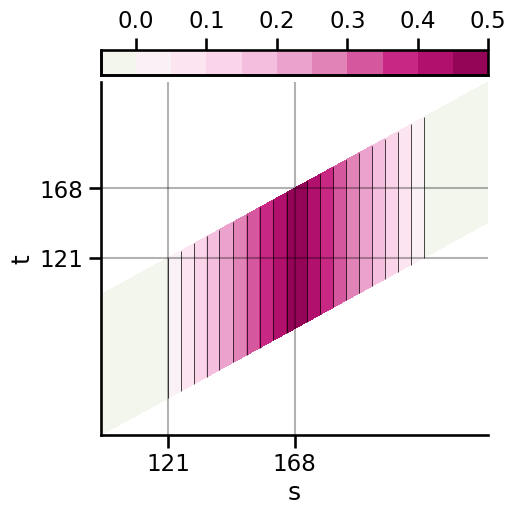

In [9]:
bapc_coef = pd.DataFrame(np.nan, index=df.index.values, columns=df.index.values)
bapc_coef.index.name = 's'
bapc_coef.columns.name = 't'
offset = 0

for s, val in explainers['y'].items():
    c = val[correction_window]
    xcoefs = np.array(c['first_base_model_at_t']) - np.array(c['second_base_model_at_t'])
    t = np.arange(n_train) + offset
    bapc_coef.loc[s, t] = xcoefs
    offset = offset+1

with sns.plotting_context("talk"):

    f, ax = heatmaps(bapc_coef, levels=10)

    if save_fig:
        f.savefig(os.path.join(fig_folder, '{}_bapc_heatmap.png'.format(csv_file)), bbox_inches='tight')

# Bottom